In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
import gzip
import shutil

In [2]:
'Functions'

def preprocess_nifti_data(data_folder):
    """
    Processes all .nii.gz files in a folder by extracting, loading, rotating, 
    and concatenating them into a single volume.
    
    Parameters:
        data_folder (str): Path to the folder containing .nii.gz files.

    Returns:
        numpy.ndarray: The final 4D array of shape (Nx, Ny, Nz * num_files, t).
    """
    volumes = []

    # List all .nii.gz files in the folder
    nii_gz_files = [f for f in os.listdir(data_folder) if f.endswith('.nii.gz')]

    for file in nii_gz_files:
        file_path = os.path.join(data_folder, file)
        extracted_path = file_path[:-3]  # Remove ".gz" to get ".nii" path

        # Extract the .nii file from .nii.gz
        with gzip.open(file_path, 'rb') as f_in, open(extracted_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

        # Load the extracted .nii file
        nii = nib.load(extracted_path)
        data = nii.get_fdata()

        # Rotate 90 degrees counterclockwise in the xy-plane
        rotated_data = np.rot90(data, k=1, axes=(0, 1))

        # Append to list
        volumes.append(rotated_data)

        # Delete the extracted .nii file after loading
        os.remove(extracted_path)

    # Concatenate along the z-axis
    final_data = np.concatenate(volumes, axis=2)

    print(f"Final shape of ground truth: {final_data.shape}; dimensions: (Nx, Ny, Nz*Nvol, t)")
    return final_data


def add_gaussian_noise(data, noise_level):
    """
    Adds Gaussian noise to each slice and timeframe in the dataset with a different noise level per slice and timeframe.

    Parameters:
        data (numpy.ndarray): The full dataset of shape (Nx, Ny, Nz*Nvol, t).
        noise_level (float): Maximum fraction of image intensity to use as noise (between 0 and 1).

    Returns:
        numpy.ndarray: The noisy dataset with the same shape as the input.
    """
    noisy_data = np.zeros_like(data)

    # Iterate over time dimension
    for t in range(data.shape[-1]):
        for z in range(data.shape[2]):  # Iterate over slices in the 3rd dimension
            # Compute slice-specific noise level as a fraction of its max intensity
            max_intensity = np.max(data[:, :, z, t])
            noise_std = np.random.uniform(0, noise_level) * max_intensity  # Scale noise

            # Add Gaussian noise to this slice
            noise = np.random.normal(0, noise_std, data[:, :, z, t].shape)
            noisy_data[:, :, z, t] = data[:, :, z, t] + noise

    print(f"Final shape of noisy dataset: {noisy_data.shape}; dimensions: (Nx, Ny, Nz*Nvol, t)")

    return noisy_data


def get_run_and_slice(slice_index, slices_per_run=39):
    """
    Input slice index from total data volume and return specific run and corresponding slice within run.

    Paramters:
        slice_index: Slice index from total volume.

    Returns:
        run: specific run from which given slice_index originates.
        
        slice_within_run: corresponding slice in run.
    """
    run = slice_index // slices_per_run + 1  # Runs are 1-based
    slice_within_run = slice_index % slices_per_run
    return run, slice_within_run

# Generate ground truth dataset

In [3]:
'Load data'

# Choose path where all .nii.gz folders are saved
data_folder = r'..\Data'
data = preprocess_nifti_data(data_folder)

Final shape of ground truth: (64, 64, 117, 300); dimensions: (Nx, Ny, Nz*Nvol, t)


In [4]:
'Save ground truth dataset'

gt_path = rf"{data_folder}\groundtruth_dataset.npy"
np.save(gt_path, data)
print(f'Ground truth dataset saved as "{gt_path}"')

Ground truth dataset saved as "..\Data\groundtruth_dataset.npy"


# Generate noisy dataset

In [5]:
'Add noise'

# Select value between 0 and 1 for maximum percentage of image highest intensity to generate noise
noisy_data = add_gaussian_noise(data, noise_level=0.1)

Final shape of noisy dataset: (64, 64, 117, 300); dimensions: (Nx, Ny, Nz*Nvol, t)


In [6]:
'Save noisy dataset'

noisy_path = rf"{data_folder}\noisy_dataset.npy"
np.save(noisy_path, noisy_data)
print(f'Noisy dataset saved as "{noisy_path}"')

Noisy dataset saved as "..\Data\noisy_dataset.npy"


# Plots

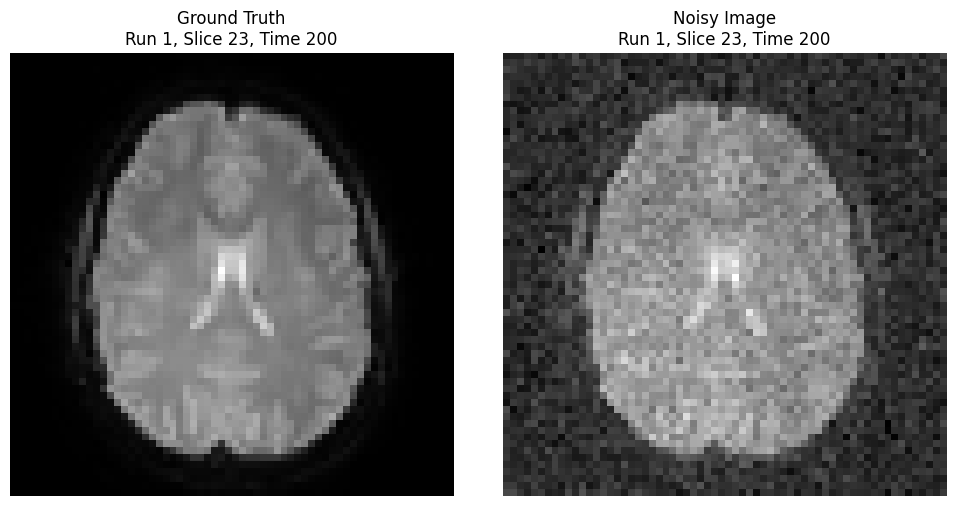

In [7]:
'Plot example slices'

# Choose slice and timeframe to plot
slice_index = 23
timeframe = 200

# Get run and corresponding slice within that run
run, slice_within_run = get_run_and_slice(slice_index)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth image
axes[0].imshow(data[:, :, slice_index, timeframe], cmap='gray')
axes[0].set_title(f'Ground Truth\nRun {run}, Slice {slice_within_run}, Time {timeframe}')
axes[0].axis("off")

# Plot noisy image
axes[1].imshow(noisy_data[:, :, slice_index, timeframe], cmap='gray')
axes[1].set_title(f'Noisy Image\nRun {run}, Slice {slice_within_run}, Time {timeframe}')
axes[1].axis("off")

# Show the plots
plt.tight_layout()
plt.show()

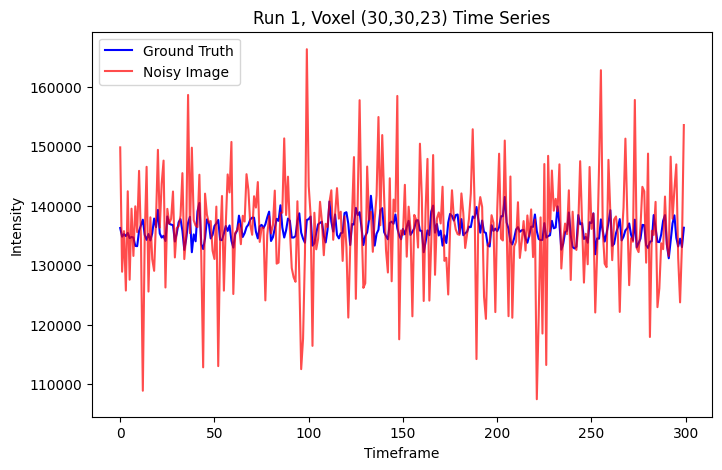

In [8]:
'Plot example voxel timeseries'

# Choose voxel and slice to plot time series
vx, vy = 30, 30

# Get run and corresponding slice within that run
run, slice_within_run = get_run_and_slice(slice_index)

# Create figure
plt.figure(figsize=(8, 5))

# Plot time series for ground truth and noisy data
plt.plot(data[vx, vy, slice_index, :], label="Ground Truth", color='b')
plt.plot(noisy_data[vx, vy, slice_index, :], label="Noisy Image", color='r', alpha=0.7)

# Add labels and title
plt.xlabel("Timeframe")
plt.ylabel("Intensity")
plt.title(f'Run {run}, Voxel ({vx},{vy},{slice_within_run}) Time Series')

# Add legend
plt.legend()

# Show plot
plt.show()